In [343]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [344]:
import time
import os

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchtext

from gensim.models.keyedvectors import KeyedVectors

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, LabelEncoder

import random
import string
import copy

from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt

In [345]:
GLOVE = 1 #Whether to use GloVe vectors or not
GLOVE_DIM = 200
BATCH_SIZE = 256
EPOCHS = 300

In [346]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
device

device(type='cuda')

In [347]:
df = pd.read_pickle("./nlp_genre/df_bal_kayla.pkl")
df_test = pd.read_pickle("./nlp_genre/df_test_kayla.pkl")

In [348]:
full_df = pd.concat([df[['lyrics_nsw_alpha_en', 'Genre']], df_test[['lyrics_nsw_alpha_en', 'Genre']]], axis=0).reset_index(drop=True)

In [349]:
le = LabelEncoder()
y = torch.tensor(le.fit_transform(full_df['Genre']))

In [350]:
class Sequences(Dataset):
    def __init__(self, path, y, max_seq_len):
        self.max_seq_len = max_seq_len
        df = path
        self.vectorizer = CountVectorizer(min_df = 0.0001, max_df = 0.6)
        self.vectorizer.fit(df['lyrics_nsw_alpha_en'].tolist())
        self.token2idx = self.vectorizer.vocabulary_
        self.token2idx['<PAD>'] = max(self.token2idx.values()) + 1
        # self.token2idx['<UNK>'] = max(self.token2idx.values()) + 1

        tokenizer = self.vectorizer.build_analyzer()
        self.encode = lambda x: [self.token2idx[token] for token in tokenizer(x)
                                 if token in self.token2idx] # Encode sentences to list of numbers based on token2idx
        self.pad = lambda x: x + (max_seq_len - len(x)) * [self.token2idx['<PAD>']]
        
        sequences = [self.encode(sequence)[:max_seq_len] for sequence in df['lyrics_nsw_alpha_en'].tolist()]
        sequences, self.labels = zip(*[(sequence, label) for sequence, label
                                    in zip(sequences, df['Genre'].tolist()) if sequence])
        self.labels = y
        self.sequences = [self.pad(sequence) for sequence in sequences]

    def __getitem__(self, i):
        assert len(self.sequences[i]) == self.max_seq_len
        return self.sequences[i], self.labels[i]
    
    def __len__(self):
        return len(self.sequences)

In [351]:
dataset = Sequences(full_df, y, max_seq_len=150)

In [352]:
len(list(dataset.token2idx.values())) # All values are continuous

11952

In [353]:
if os.path.isfile('./glove'+str(GLOVE_DIM)+'.pth'):
    glove = torch.load('glove'+str(GLOVE_DIM)+'.pth')
else:
    glove = torchtext.vocab.GloVe(name='6B', dim=GLOVE_DIM)
    torch.save(glove, 'glove'+str(GLOVE_DIM)+'.pth')

In [354]:
def get_word(word):
    return glove.vectors[glove.stoi[word]]

In [355]:
get_word('google')

tensor([ 0.0223,  0.6323,  0.0537, -0.5883,  1.5983, -0.6531,  0.1353, -0.1646,
        -0.3086,  0.1617, -0.3085,  0.6127,  0.3503,  0.1564,  0.4244, -0.1902,
         0.2166,  0.3397, -0.7665, -0.2831, -0.7306,  1.7593, -0.6000, -0.2579,
        -0.1032,  0.5230, -0.2549,  0.3999, -0.1720, -0.0892, -0.7228, -0.5832,
         0.2521,  0.5610,  0.1907, -0.1670, -0.4659, -0.4942, -0.6210, -0.2511,
         0.0605,  0.0444,  0.1720,  0.2110, -0.4275, -0.0352, -0.1337, -1.5494,
        -0.0687,  0.2519, -0.7870,  0.0614,  0.5545,  0.0709,  0.0217,  0.3962,
        -0.6723,  0.4086, -0.1180,  0.1889,  0.3885,  0.4262,  0.2296, -0.0063,
         0.6407, -0.6211, -0.6388, -0.0440,  0.6361,  0.0320,  0.1663,  0.8558,
         0.3586, -0.6978, -0.0394,  0.7530, -0.1823, -0.0817, -0.2397,  0.4678,
         0.1466,  0.4188,  0.2506, -0.0937,  0.1945, -0.0577, -0.3952,  0.3010,
         0.7088, -0.5207,  0.9172, -0.3887, -0.4343,  0.3175, -0.1777,  0.2727,
        -0.0944, -0.2675,  0.1165, -0.18

In [356]:
matrix_len = len(dataset.token2idx)
weights_matrix = np.zeros((matrix_len, GLOVE_DIM))
words_found = 0

for i, word in enumerate(dataset.token2idx):
    try: 
        weights_matrix[i] = get_word(word)
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(GLOVE_DIM, ))

if torch.cuda.is_available():
    weights_matrix = torch.from_numpy(weights_matrix)

In [357]:
weights_matrix[0]

tensor([-0.5757,  0.2476,  0.6036, -0.7066,  0.1330,  0.0645, -0.3722,  0.0820,
         0.2689, -0.4784,  0.3192,  0.4360, -0.0678,  0.1976,  0.3499, -0.2388,
         0.6569,  0.5694, -0.3032,  0.0404,  0.3834,  2.0915,  0.1603, -0.0478,
         0.3433,  0.4193, -0.2049, -0.4519,  0.0574, -0.1299, -0.5669,  0.5079,
         0.4608, -0.1612, -0.1594, -0.3914, -0.1971, -0.9754,  0.5267, -0.9078,
        -0.3442, -0.5726, -0.1176, -0.3716, -0.0287, -0.2959,  0.6834, -0.0634,
         0.4358, -0.0257, -0.4374, -0.2863,  0.2014, -0.1245,  0.1629,  0.1266,
        -0.4198,  0.5504,  0.2097,  0.0872, -0.1600,  0.3340, -0.6960,  0.2048,
        -0.5889, -0.6512,  0.2131,  0.2940, -0.0578,  0.6971, -0.1130, -0.1040,
         0.1059, -0.2025, -0.3038,  0.0817,  0.0638, -0.5507, -0.3494, -0.1454,
         0.3335, -0.2376, -0.7563,  0.7106,  0.3785,  0.2133, -0.6232, -0.1999,
         0.3753, -0.5172, -0.0523,  0.0298,  0.4749,  0.0549, -0.2418,  0.9309,
         0.3967, -0.7307, -0.4570,  0.02

In [358]:
train_split = 0.7
train_size = int(train_split * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [359]:
def collate(batch):
    inputs = torch.LongTensor([item[0] for item in batch])
    target = torch.LongTensor([item[1] for item in batch])
    return inputs, target

batch_size = BATCH_SIZE
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate, shuffle=True, num_workers = 8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate, shuffle=True, num_workers = 8)

In [360]:
class LSTM(nn.Module):
    def __init__(
        self,
        batch_size,
        vocab_size = None,
        weights_matrix = None,
        embedding_dimension=300,
        hidden_size=64, 
        n_layers=2,
        device=device,
        dropout=0.2
    ):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.device = device
        self.batch_size = batch_size
        
        if weights_matrix is not None:
            self.encoder, num_embeddings, embedding_dimension = self.create_emb_layer(weights_matrix, True)
        else:
            self.encoder = nn.Embedding(vocab_size, embedding_dimension)
        
        self.rnn = nn.LSTM(
            embedding_dimension,
            hidden_size,
            dropout=dropout,
            num_layers=n_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 64)
        self.relu =nn.ReLU()
        self.do = nn.Dropout(p=dropout)
        self.decoder = nn.Linear(64, 6)
        self.sm = nn.Softmax(1)
        
    def create_emb_layer(self, weights_matrix, non_trainable=False):
        num_embeddings, embedding_dim = weights_matrix.shape
        emb_layer = nn.Embedding(num_embeddings, embedding_dim)
        emb_layer.load_state_dict({'weight': weights_matrix})
        
        if non_trainable:
            emb_layer.weight.requires_grad = False

        return emb_layer, num_embeddings, embedding_dim
        
    def init_hidden(self):
        h0 = torch.randn(self.n_layers, self.batch_size, self.hidden_size).to(self.device)
        c0 = torch.randn(self.n_layers, self.batch_size, self.hidden_size).to(self.device)
        return (h0, c0)
    
    def forward(self, inputs):
        # Avoid breaking if the last batch has a different size
        batch_size = inputs.size(0)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
            
        h0, c0 = self.init_hidden()
        encoded = self.encoder(inputs) # 512x128 -> 512x128x100
        output, (hidden, cell) = self.rnn(encoded, (h0, c0)) #512x128x100 -> 512x128x128
        output = self.fc(output[:, -1, :])
        output = self.relu(output)
        output = self.do(output)
        output = self.decoder(output).squeeze() #512x128 -> 512x6
        output = self.sm(output)
        return output

In [361]:
if GLOVE:
    model = LSTM(
        hidden_size=128,
        weights_matrix = weights_matrix,
        device=device,
        batch_size=batch_size,
    )    
else:
    model = LSTM(
        hidden_size=256,
        vocab_size=len(dataset.token2idx),
        device=device,
        batch_size=batch_size,
    )
model = model.to(device)
model

LSTM(
  (encoder): Embedding(11952, 200)
  (rnn): LSTM(200, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (do): Dropout(p=0.2, inplace=False)
  (decoder): Linear(in_features=64, out_features=6, bias=True)
  (sm): Softmax(dim=1)
)

In [362]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [363]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim=1, keepdim=True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum().to(device)/torch.FloatTensor([y.shape[0]]).to(device)

In [364]:
def train(model, train_loader):
    model.train()
    progress_bar = tqdm_notebook(train_loader, leave=False)
    train_batch_losses = []
    train_batch_accuracy = []
    total = 0
    
    for inputs, target in progress_bar:
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(inputs).to(device)
        # print(output.shape, target.shape)
        loss = criterion(output, target)
        acc = categorical_accuracy(output, target)
        
        loss.backward()
              
        # nn.utils.clip_grad_norm_(model.parameters(), 3)

        optimizer.step()
        
        progress_bar.set_description(f'Loss: {loss.item():.3f}')
        
        train_batch_losses.append(loss.item())
        train_batch_accuracy.append(acc.item())
        total += 1
    # print(output.shape, target.shape)    
    return train_batch_losses, train_batch_accuracy, total
    

In [365]:
def evalu(model, test_loader):
    model.eval()
    progress_bar = tqdm_notebook(test_loader, leave=False)
    eval_batch_loss = []
    eval_batch_acc = []
    total = 0

    with torch.no_grad():
        for inputs, target in progress_bar:
            inputs, target = inputs.to(device), target.to(device)
            predictions = model(inputs)

            loss = criterion(predictions, target)

            acc = categorical_accuracy(predictions, target)

            eval_batch_loss.append(loss.item())
            eval_batch_acc.append(acc.item())
            total += 1
    
    return eval_batch_loss, eval_batch_acc, total

In [366]:
train_losses = []
train_accuracy = []
eval_losses = []
eval_accuracy = []
for epoch in range(EPOCHS):
    train_batch_losses, train_batch_accuracy, total = train(model, train_loader)
    eval_batch_loss, eval_batch_acc, total_ = evalu(model, test_loader)

    
    train_epoch_loss = sum(train_batch_losses) / total
    train_epoch_acc = sum(train_batch_accuracy) / total
    
    eval_epoch_loss = sum(eval_batch_loss) / total_
    eval_epoch_acc = sum(eval_batch_acc) / total_
    
    train_losses.append(train_epoch_loss)
    train_accuracy.append(train_epoch_acc)
    
    eval_losses.append(eval_epoch_loss)
    eval_accuracy.append(eval_epoch_acc)
    
    tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {train_epoch_loss:.3f} \tTrain Accuracy: {train_epoch_acc:.3f}')
    tqdm.write(f'Epoch #{epoch + 1}\tEval Loss: {eval_epoch_loss:.3f} \tEval Accuracy: {eval_epoch_acc:.3f}')

/tmp/ipykernel_15799/589472987.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(train_loader, leave=False)


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #1	Train Loss: 1.752 	Train Accuracy: 0.245
Epoch #1	Eval Loss: 1.735 	Eval Accuracy: 0.267


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #2	Train Loss: 1.734 	Train Accuracy: 0.273
Epoch #2	Eval Loss: 1.728 	Eval Accuracy: 0.272


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #3	Train Loss: 1.723 	Train Accuracy: 0.281
Epoch #3	Eval Loss: 1.738 	Eval Accuracy: 0.274


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #4	Train Loss: 1.709 	Train Accuracy: 0.306
Epoch #4	Eval Loss: 1.693 	Eval Accuracy: 0.330


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #5	Train Loss: 1.687 	Train Accuracy: 0.336
Epoch #5	Eval Loss: 1.671 	Eval Accuracy: 0.351


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #6	Train Loss: 1.683 	Train Accuracy: 0.343
Epoch #6	Eval Loss: 1.668 	Eval Accuracy: 0.353


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #7	Train Loss: 1.668 	Train Accuracy: 0.353
Epoch #7	Eval Loss: 1.671 	Eval Accuracy: 0.359


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #8	Train Loss: 1.653 	Train Accuracy: 0.369
Epoch #8	Eval Loss: 1.651 	Eval Accuracy: 0.372


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #9	Train Loss: 1.647 	Train Accuracy: 0.376
Epoch #9	Eval Loss: 1.649 	Eval Accuracy: 0.372


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #10	Train Loss: 1.640 	Train Accuracy: 0.382
Epoch #10	Eval Loss: 1.665 	Eval Accuracy: 0.352


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #11	Train Loss: 1.641 	Train Accuracy: 0.381
Epoch #11	Eval Loss: 1.649 	Eval Accuracy: 0.371


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #12	Train Loss: 1.636 	Train Accuracy: 0.387
Epoch #12	Eval Loss: 1.646 	Eval Accuracy: 0.376


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #13	Train Loss: 1.625 	Train Accuracy: 0.397
Epoch #13	Eval Loss: 1.640 	Eval Accuracy: 0.384


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #14	Train Loss: 1.623 	Train Accuracy: 0.399
Epoch #14	Eval Loss: 1.656 	Eval Accuracy: 0.361


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #15	Train Loss: 1.618 	Train Accuracy: 0.405
Epoch #15	Eval Loss: 1.642 	Eval Accuracy: 0.379


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #16	Train Loss: 1.621 	Train Accuracy: 0.401
Epoch #16	Eval Loss: 1.636 	Eval Accuracy: 0.385


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #17	Train Loss: 1.615 	Train Accuracy: 0.408
Epoch #17	Eval Loss: 1.630 	Eval Accuracy: 0.391


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #18	Train Loss: 1.609 	Train Accuracy: 0.413
Epoch #18	Eval Loss: 1.631 	Eval Accuracy: 0.393


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #19	Train Loss: 1.602 	Train Accuracy: 0.423
Epoch #19	Eval Loss: 1.627 	Eval Accuracy: 0.393


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #20	Train Loss: 1.602 	Train Accuracy: 0.422
Epoch #20	Eval Loss: 1.627 	Eval Accuracy: 0.397


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #21	Train Loss: 1.598 	Train Accuracy: 0.427
Epoch #21	Eval Loss: 1.627 	Eval Accuracy: 0.392


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #22	Train Loss: 1.591 	Train Accuracy: 0.433
Epoch #22	Eval Loss: 1.622 	Eval Accuracy: 0.402


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #23	Train Loss: 1.593 	Train Accuracy: 0.431
Epoch #23	Eval Loss: 1.624 	Eval Accuracy: 0.396


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #24	Train Loss: 1.589 	Train Accuracy: 0.437
Epoch #24	Eval Loss: 1.615 	Eval Accuracy: 0.410


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #25	Train Loss: 1.583 	Train Accuracy: 0.443
Epoch #25	Eval Loss: 1.616 	Eval Accuracy: 0.407


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #26	Train Loss: 1.586 	Train Accuracy: 0.439
Epoch #26	Eval Loss: 1.613 	Eval Accuracy: 0.412


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #27	Train Loss: 1.580 	Train Accuracy: 0.446
Epoch #27	Eval Loss: 1.616 	Eval Accuracy: 0.410


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #28	Train Loss: 1.577 	Train Accuracy: 0.453
Epoch #28	Eval Loss: 1.621 	Eval Accuracy: 0.405


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #29	Train Loss: 1.571 	Train Accuracy: 0.458
Epoch #29	Eval Loss: 1.608 	Eval Accuracy: 0.417


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #30	Train Loss: 1.564 	Train Accuracy: 0.466
Epoch #30	Eval Loss: 1.613 	Eval Accuracy: 0.408


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #31	Train Loss: 1.562 	Train Accuracy: 0.469
Epoch #31	Eval Loss: 1.609 	Eval Accuracy: 0.416


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #32	Train Loss: 1.558 	Train Accuracy: 0.474
Epoch #32	Eval Loss: 1.606 	Eval Accuracy: 0.423


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #33	Train Loss: 1.550 	Train Accuracy: 0.483
Epoch #33	Eval Loss: 1.607 	Eval Accuracy: 0.421


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #34	Train Loss: 1.555 	Train Accuracy: 0.479
Epoch #34	Eval Loss: 1.607 	Eval Accuracy: 0.422


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #35	Train Loss: 1.543 	Train Accuracy: 0.493
Epoch #35	Eval Loss: 1.609 	Eval Accuracy: 0.420


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #36	Train Loss: 1.542 	Train Accuracy: 0.494
Epoch #36	Eval Loss: 1.607 	Eval Accuracy: 0.425


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #37	Train Loss: 1.537 	Train Accuracy: 0.500
Epoch #37	Eval Loss: 1.607 	Eval Accuracy: 0.427


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #38	Train Loss: 1.535 	Train Accuracy: 0.503
Epoch #38	Eval Loss: 1.605 	Eval Accuracy: 0.427


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #39	Train Loss: 1.527 	Train Accuracy: 0.511
Epoch #39	Eval Loss: 1.608 	Eval Accuracy: 0.422


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #40	Train Loss: 1.520 	Train Accuracy: 0.518
Epoch #40	Eval Loss: 1.615 	Eval Accuracy: 0.419


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #41	Train Loss: 1.520 	Train Accuracy: 0.518
Epoch #41	Eval Loss: 1.605 	Eval Accuracy: 0.430


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #42	Train Loss: 1.517 	Train Accuracy: 0.522
Epoch #42	Eval Loss: 1.616 	Eval Accuracy: 0.419


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #43	Train Loss: 1.514 	Train Accuracy: 0.524
Epoch #43	Eval Loss: 1.608 	Eval Accuracy: 0.426


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #44	Train Loss: 1.506 	Train Accuracy: 0.534
Epoch #44	Eval Loss: 1.603 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #45	Train Loss: 1.501 	Train Accuracy: 0.539
Epoch #45	Eval Loss: 1.605 	Eval Accuracy: 0.429


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #46	Train Loss: 1.499 	Train Accuracy: 0.540
Epoch #46	Eval Loss: 1.607 	Eval Accuracy: 0.428


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #47	Train Loss: 1.507 	Train Accuracy: 0.533
Epoch #47	Eval Loss: 1.606 	Eval Accuracy: 0.432


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #48	Train Loss: 1.505 	Train Accuracy: 0.534
Epoch #48	Eval Loss: 1.616 	Eval Accuracy: 0.420


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #49	Train Loss: 1.498 	Train Accuracy: 0.543
Epoch #49	Eval Loss: 1.606 	Eval Accuracy: 0.432


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #50	Train Loss: 1.493 	Train Accuracy: 0.548
Epoch #50	Eval Loss: 1.611 	Eval Accuracy: 0.426


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #51	Train Loss: 1.491 	Train Accuracy: 0.550
Epoch #51	Eval Loss: 1.607 	Eval Accuracy: 0.432


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #52	Train Loss: 1.485 	Train Accuracy: 0.556
Epoch #52	Eval Loss: 1.607 	Eval Accuracy: 0.431


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #53	Train Loss: 1.479 	Train Accuracy: 0.561
Epoch #53	Eval Loss: 1.606 	Eval Accuracy: 0.432


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #54	Train Loss: 1.476 	Train Accuracy: 0.565
Epoch #54	Eval Loss: 1.604 	Eval Accuracy: 0.432


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #55	Train Loss: 1.477 	Train Accuracy: 0.564
Epoch #55	Eval Loss: 1.611 	Eval Accuracy: 0.425


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #56	Train Loss: 1.475 	Train Accuracy: 0.566
Epoch #56	Eval Loss: 1.604 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #57	Train Loss: 1.477 	Train Accuracy: 0.564
Epoch #57	Eval Loss: 1.608 	Eval Accuracy: 0.430


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #58	Train Loss: 1.466 	Train Accuracy: 0.575
Epoch #58	Eval Loss: 1.606 	Eval Accuracy: 0.433


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #59	Train Loss: 1.467 	Train Accuracy: 0.574
Epoch #59	Eval Loss: 1.605 	Eval Accuracy: 0.435


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #60	Train Loss: 1.466 	Train Accuracy: 0.576
Epoch #60	Eval Loss: 1.613 	Eval Accuracy: 0.426


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #61	Train Loss: 1.464 	Train Accuracy: 0.578
Epoch #61	Eval Loss: 1.608 	Eval Accuracy: 0.431


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #62	Train Loss: 1.466 	Train Accuracy: 0.575
Epoch #62	Eval Loss: 1.607 	Eval Accuracy: 0.432


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #63	Train Loss: 1.461 	Train Accuracy: 0.580
Epoch #63	Eval Loss: 1.607 	Eval Accuracy: 0.431


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #64	Train Loss: 1.454 	Train Accuracy: 0.587
Epoch #64	Eval Loss: 1.602 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #65	Train Loss: 1.453 	Train Accuracy: 0.589
Epoch #65	Eval Loss: 1.607 	Eval Accuracy: 0.433


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #66	Train Loss: 1.453 	Train Accuracy: 0.589
Epoch #66	Eval Loss: 1.610 	Eval Accuracy: 0.431


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #67	Train Loss: 1.452 	Train Accuracy: 0.589
Epoch #67	Eval Loss: 1.607 	Eval Accuracy: 0.431


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #68	Train Loss: 1.451 	Train Accuracy: 0.591
Epoch #68	Eval Loss: 1.613 	Eval Accuracy: 0.427


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #69	Train Loss: 1.448 	Train Accuracy: 0.594
Epoch #69	Eval Loss: 1.609 	Eval Accuracy: 0.431


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #70	Train Loss: 1.445 	Train Accuracy: 0.597
Epoch #70	Eval Loss: 1.604 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #71	Train Loss: 1.439 	Train Accuracy: 0.603
Epoch #71	Eval Loss: 1.604 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #72	Train Loss: 1.443 	Train Accuracy: 0.599
Epoch #72	Eval Loss: 1.612 	Eval Accuracy: 0.427


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #73	Train Loss: 1.447 	Train Accuracy: 0.595
Epoch #73	Eval Loss: 1.604 	Eval Accuracy: 0.435


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #74	Train Loss: 1.442 	Train Accuracy: 0.600
Epoch #74	Eval Loss: 1.604 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #75	Train Loss: 1.444 	Train Accuracy: 0.599
Epoch #75	Eval Loss: 1.606 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #76	Train Loss: 1.443 	Train Accuracy: 0.599
Epoch #76	Eval Loss: 1.604 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #77	Train Loss: 1.450 	Train Accuracy: 0.592
Epoch #77	Eval Loss: 1.612 	Eval Accuracy: 0.429


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #78	Train Loss: 1.446 	Train Accuracy: 0.596
Epoch #78	Eval Loss: 1.604 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #79	Train Loss: 1.438 	Train Accuracy: 0.604
Epoch #79	Eval Loss: 1.611 	Eval Accuracy: 0.428


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #80	Train Loss: 1.433 	Train Accuracy: 0.610
Epoch #80	Eval Loss: 1.606 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #81	Train Loss: 1.435 	Train Accuracy: 0.607
Epoch #81	Eval Loss: 1.606 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #82	Train Loss: 1.437 	Train Accuracy: 0.605
Epoch #82	Eval Loss: 1.606 	Eval Accuracy: 0.435


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #83	Train Loss: 1.433 	Train Accuracy: 0.609
Epoch #83	Eval Loss: 1.606 	Eval Accuracy: 0.433


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #84	Train Loss: 1.427 	Train Accuracy: 0.615
Epoch #84	Eval Loss: 1.604 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #85	Train Loss: 1.422 	Train Accuracy: 0.620
Epoch #85	Eval Loss: 1.605 	Eval Accuracy: 0.435


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #86	Train Loss: 1.426 	Train Accuracy: 0.616
Epoch #86	Eval Loss: 1.609 	Eval Accuracy: 0.430


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #87	Train Loss: 1.424 	Train Accuracy: 0.618
Epoch #87	Eval Loss: 1.607 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #88	Train Loss: 1.426 	Train Accuracy: 0.616
Epoch #88	Eval Loss: 1.604 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #89	Train Loss: 1.423 	Train Accuracy: 0.619
Epoch #89	Eval Loss: 1.604 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #90	Train Loss: 1.425 	Train Accuracy: 0.618
Epoch #90	Eval Loss: 1.604 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #91	Train Loss: 1.422 	Train Accuracy: 0.621
Epoch #91	Eval Loss: 1.604 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #92	Train Loss: 1.425 	Train Accuracy: 0.617
Epoch #92	Eval Loss: 1.604 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #93	Train Loss: 1.433 	Train Accuracy: 0.609
Epoch #93	Eval Loss: 1.602 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #94	Train Loss: 1.424 	Train Accuracy: 0.618
Epoch #94	Eval Loss: 1.601 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #95	Train Loss: 1.419 	Train Accuracy: 0.624
Epoch #95	Eval Loss: 1.603 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #96	Train Loss: 1.418 	Train Accuracy: 0.624
Epoch #96	Eval Loss: 1.602 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #97	Train Loss: 1.411 	Train Accuracy: 0.632
Epoch #97	Eval Loss: 1.604 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #98	Train Loss: 1.414 	Train Accuracy: 0.628
Epoch #98	Eval Loss: 1.604 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #99	Train Loss: 1.419 	Train Accuracy: 0.624
Epoch #99	Eval Loss: 1.603 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #100	Train Loss: 1.417 	Train Accuracy: 0.626
Epoch #100	Eval Loss: 1.609 	Eval Accuracy: 0.431


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #101	Train Loss: 1.419 	Train Accuracy: 0.624
Epoch #101	Eval Loss: 1.603 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #102	Train Loss: 1.415 	Train Accuracy: 0.627
Epoch #102	Eval Loss: 1.610 	Eval Accuracy: 0.431


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #103	Train Loss: 1.426 	Train Accuracy: 0.617
Epoch #103	Eval Loss: 1.606 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #104	Train Loss: 1.420 	Train Accuracy: 0.623
Epoch #104	Eval Loss: 1.606 	Eval Accuracy: 0.435


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #105	Train Loss: 1.416 	Train Accuracy: 0.627
Epoch #105	Eval Loss: 1.604 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #106	Train Loss: 1.409 	Train Accuracy: 0.633
Epoch #106	Eval Loss: 1.607 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #107	Train Loss: 1.413 	Train Accuracy: 0.629
Epoch #107	Eval Loss: 1.606 	Eval Accuracy: 0.435


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #108	Train Loss: 1.407 	Train Accuracy: 0.635
Epoch #108	Eval Loss: 1.613 	Eval Accuracy: 0.427


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #109	Train Loss: 1.403 	Train Accuracy: 0.640
Epoch #109	Eval Loss: 1.609 	Eval Accuracy: 0.431


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #110	Train Loss: 1.402 	Train Accuracy: 0.640
Epoch #110	Eval Loss: 1.608 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #111	Train Loss: 1.405 	Train Accuracy: 0.638
Epoch #111	Eval Loss: 1.604 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #112	Train Loss: 1.403 	Train Accuracy: 0.640
Epoch #112	Eval Loss: 1.603 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #113	Train Loss: 1.400 	Train Accuracy: 0.642
Epoch #113	Eval Loss: 1.604 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #114	Train Loss: 1.397 	Train Accuracy: 0.645
Epoch #114	Eval Loss: 1.604 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #115	Train Loss: 1.397 	Train Accuracy: 0.645
Epoch #115	Eval Loss: 1.605 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #116	Train Loss: 1.397 	Train Accuracy: 0.646
Epoch #116	Eval Loss: 1.605 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #117	Train Loss: 1.393 	Train Accuracy: 0.650
Epoch #117	Eval Loss: 1.612 	Eval Accuracy: 0.429


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #118	Train Loss: 1.396 	Train Accuracy: 0.647
Epoch #118	Eval Loss: 1.608 	Eval Accuracy: 0.433


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #119	Train Loss: 1.397 	Train Accuracy: 0.646
Epoch #119	Eval Loss: 1.606 	Eval Accuracy: 0.435


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #120	Train Loss: 1.396 	Train Accuracy: 0.647
Epoch #120	Eval Loss: 1.606 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #121	Train Loss: 1.399 	Train Accuracy: 0.644
Epoch #121	Eval Loss: 1.604 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #122	Train Loss: 1.394 	Train Accuracy: 0.648
Epoch #122	Eval Loss: 1.614 	Eval Accuracy: 0.427


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #123	Train Loss: 1.395 	Train Accuracy: 0.647
Epoch #123	Eval Loss: 1.604 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #124	Train Loss: 1.398 	Train Accuracy: 0.644
Epoch #124	Eval Loss: 1.607 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #125	Train Loss: 1.395 	Train Accuracy: 0.648
Epoch #125	Eval Loss: 1.608 	Eval Accuracy: 0.433


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #126	Train Loss: 1.399 	Train Accuracy: 0.644
Epoch #126	Eval Loss: 1.606 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #127	Train Loss: 1.395 	Train Accuracy: 0.647
Epoch #127	Eval Loss: 1.612 	Eval Accuracy: 0.429


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #128	Train Loss: 1.394 	Train Accuracy: 0.649
Epoch #128	Eval Loss: 1.610 	Eval Accuracy: 0.431


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #129	Train Loss: 1.393 	Train Accuracy: 0.650
Epoch #129	Eval Loss: 1.604 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #130	Train Loss: 1.391 	Train Accuracy: 0.652
Epoch #130	Eval Loss: 1.609 	Eval Accuracy: 0.431


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #131	Train Loss: 1.405 	Train Accuracy: 0.637
Epoch #131	Eval Loss: 1.607 	Eval Accuracy: 0.433


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #132	Train Loss: 1.395 	Train Accuracy: 0.648
Epoch #132	Eval Loss: 1.606 	Eval Accuracy: 0.435


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #133	Train Loss: 1.391 	Train Accuracy: 0.651
Epoch #133	Eval Loss: 1.613 	Eval Accuracy: 0.427


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #134	Train Loss: 1.394 	Train Accuracy: 0.648
Epoch #134	Eval Loss: 1.611 	Eval Accuracy: 0.430


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #135	Train Loss: 1.390 	Train Accuracy: 0.652
Epoch #135	Eval Loss: 1.604 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #136	Train Loss: 1.388 	Train Accuracy: 0.654
Epoch #136	Eval Loss: 1.610 	Eval Accuracy: 0.431


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #137	Train Loss: 1.390 	Train Accuracy: 0.653
Epoch #137	Eval Loss: 1.611 	Eval Accuracy: 0.430


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #138	Train Loss: 1.392 	Train Accuracy: 0.651
Epoch #138	Eval Loss: 1.610 	Eval Accuracy: 0.430


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #139	Train Loss: 1.383 	Train Accuracy: 0.659
Epoch #139	Eval Loss: 1.604 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #140	Train Loss: 1.383 	Train Accuracy: 0.660
Epoch #140	Eval Loss: 1.604 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #141	Train Loss: 1.383 	Train Accuracy: 0.660
Epoch #141	Eval Loss: 1.607 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #142	Train Loss: 1.382 	Train Accuracy: 0.660
Epoch #142	Eval Loss: 1.605 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #143	Train Loss: 1.380 	Train Accuracy: 0.663
Epoch #143	Eval Loss: 1.606 	Eval Accuracy: 0.435


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #144	Train Loss: 1.381 	Train Accuracy: 0.661
Epoch #144	Eval Loss: 1.606 	Eval Accuracy: 0.435


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #145	Train Loss: 1.380 	Train Accuracy: 0.662
Epoch #145	Eval Loss: 1.605 	Eval Accuracy: 0.435


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #146	Train Loss: 1.383 	Train Accuracy: 0.659
Epoch #146	Eval Loss: 1.605 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #147	Train Loss: 1.380 	Train Accuracy: 0.663
Epoch #147	Eval Loss: 1.600 	Eval Accuracy: 0.441


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #148	Train Loss: 1.389 	Train Accuracy: 0.654
Epoch #148	Eval Loss: 1.601 	Eval Accuracy: 0.440


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #149	Train Loss: 1.383 	Train Accuracy: 0.660
Epoch #149	Eval Loss: 1.604 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #150	Train Loss: 1.379 	Train Accuracy: 0.663
Epoch #150	Eval Loss: 1.603 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #151	Train Loss: 1.377 	Train Accuracy: 0.666
Epoch #151	Eval Loss: 1.603 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #152	Train Loss: 1.374 	Train Accuracy: 0.669
Epoch #152	Eval Loss: 1.603 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #153	Train Loss: 1.371 	Train Accuracy: 0.672
Epoch #153	Eval Loss: 1.605 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #154	Train Loss: 1.371 	Train Accuracy: 0.672
Epoch #154	Eval Loss: 1.602 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #155	Train Loss: 1.373 	Train Accuracy: 0.669
Epoch #155	Eval Loss: 1.605 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #156	Train Loss: 1.370 	Train Accuracy: 0.672
Epoch #156	Eval Loss: 1.606 	Eval Accuracy: 0.435


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #157	Train Loss: 1.373 	Train Accuracy: 0.671
Epoch #157	Eval Loss: 1.604 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #158	Train Loss: 1.372 	Train Accuracy: 0.671
Epoch #158	Eval Loss: 1.606 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #159	Train Loss: 1.368 	Train Accuracy: 0.674
Epoch #159	Eval Loss: 1.603 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #160	Train Loss: 1.374 	Train Accuracy: 0.669
Epoch #160	Eval Loss: 1.612 	Eval Accuracy: 0.429


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #161	Train Loss: 1.373 	Train Accuracy: 0.670
Epoch #161	Eval Loss: 1.607 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #162	Train Loss: 1.375 	Train Accuracy: 0.668
Epoch #162	Eval Loss: 1.606 	Eval Accuracy: 0.435


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #163	Train Loss: 1.372 	Train Accuracy: 0.671
Epoch #163	Eval Loss: 1.601 	Eval Accuracy: 0.440


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #164	Train Loss: 1.374 	Train Accuracy: 0.669
Epoch #164	Eval Loss: 1.601 	Eval Accuracy: 0.440


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #165	Train Loss: 1.369 	Train Accuracy: 0.674
Epoch #165	Eval Loss: 1.601 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #166	Train Loss: 1.370 	Train Accuracy: 0.673
Epoch #166	Eval Loss: 1.599 	Eval Accuracy: 0.443


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #167	Train Loss: 1.368 	Train Accuracy: 0.674
Epoch #167	Eval Loss: 1.606 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #168	Train Loss: 1.387 	Train Accuracy: 0.656
Epoch #168	Eval Loss: 1.609 	Eval Accuracy: 0.432


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #169	Train Loss: 1.377 	Train Accuracy: 0.665
Epoch #169	Eval Loss: 1.605 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #170	Train Loss: 1.371 	Train Accuracy: 0.671
Epoch #170	Eval Loss: 1.607 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #171	Train Loss: 1.373 	Train Accuracy: 0.670
Epoch #171	Eval Loss: 1.604 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #172	Train Loss: 1.371 	Train Accuracy: 0.671
Epoch #172	Eval Loss: 1.600 	Eval Accuracy: 0.441


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #173	Train Loss: 1.374 	Train Accuracy: 0.669
Epoch #173	Eval Loss: 1.603 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #174	Train Loss: 1.369 	Train Accuracy: 0.674
Epoch #174	Eval Loss: 1.605 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #175	Train Loss: 1.368 	Train Accuracy: 0.675
Epoch #175	Eval Loss: 1.600 	Eval Accuracy: 0.440


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #176	Train Loss: 1.366 	Train Accuracy: 0.677
Epoch #176	Eval Loss: 1.602 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #177	Train Loss: 1.364 	Train Accuracy: 0.679
Epoch #177	Eval Loss: 1.599 	Eval Accuracy: 0.441


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #178	Train Loss: 1.362 	Train Accuracy: 0.680
Epoch #178	Eval Loss: 1.602 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #179	Train Loss: 1.358 	Train Accuracy: 0.685
Epoch #179	Eval Loss: 1.602 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #180	Train Loss: 1.361 	Train Accuracy: 0.682
Epoch #180	Eval Loss: 1.606 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #181	Train Loss: 1.359 	Train Accuracy: 0.683
Epoch #181	Eval Loss: 1.603 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #182	Train Loss: 1.357 	Train Accuracy: 0.686
Epoch #182	Eval Loss: 1.604 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #183	Train Loss: 1.358 	Train Accuracy: 0.685
Epoch #183	Eval Loss: 1.604 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #184	Train Loss: 1.357 	Train Accuracy: 0.686
Epoch #184	Eval Loss: 1.606 	Eval Accuracy: 0.435


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #185	Train Loss: 1.360 	Train Accuracy: 0.683
Epoch #185	Eval Loss: 1.604 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #186	Train Loss: 1.359 	Train Accuracy: 0.684
Epoch #186	Eval Loss: 1.601 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #187	Train Loss: 1.359 	Train Accuracy: 0.684
Epoch #187	Eval Loss: 1.604 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #188	Train Loss: 1.353 	Train Accuracy: 0.689
Epoch #188	Eval Loss: 1.608 	Eval Accuracy: 0.432


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #189	Train Loss: 1.358 	Train Accuracy: 0.685
Epoch #189	Eval Loss: 1.606 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #190	Train Loss: 1.354 	Train Accuracy: 0.689
Epoch #190	Eval Loss: 1.604 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #191	Train Loss: 1.356 	Train Accuracy: 0.687
Epoch #191	Eval Loss: 1.608 	Eval Accuracy: 0.432


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #192	Train Loss: 1.352 	Train Accuracy: 0.691
Epoch #192	Eval Loss: 1.606 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #193	Train Loss: 1.350 	Train Accuracy: 0.693
Epoch #193	Eval Loss: 1.603 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #194	Train Loss: 1.348 	Train Accuracy: 0.694
Epoch #194	Eval Loss: 1.601 	Eval Accuracy: 0.440


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #195	Train Loss: 1.359 	Train Accuracy: 0.683
Epoch #195	Eval Loss: 1.608 	Eval Accuracy: 0.433


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #196	Train Loss: 1.353 	Train Accuracy: 0.689
Epoch #196	Eval Loss: 1.603 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #197	Train Loss: 1.349 	Train Accuracy: 0.693
Epoch #197	Eval Loss: 1.601 	Eval Accuracy: 0.440


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #198	Train Loss: 1.349 	Train Accuracy: 0.694
Epoch #198	Eval Loss: 1.606 	Eval Accuracy: 0.435


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #199	Train Loss: 1.349 	Train Accuracy: 0.693
Epoch #199	Eval Loss: 1.601 	Eval Accuracy: 0.440


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #200	Train Loss: 1.350 	Train Accuracy: 0.693
Epoch #200	Eval Loss: 1.603 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #201	Train Loss: 1.348 	Train Accuracy: 0.695
Epoch #201	Eval Loss: 1.606 	Eval Accuracy: 0.435


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #202	Train Loss: 1.348 	Train Accuracy: 0.695
Epoch #202	Eval Loss: 1.603 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #203	Train Loss: 1.350 	Train Accuracy: 0.693
Epoch #203	Eval Loss: 1.607 	Eval Accuracy: 0.433


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #204	Train Loss: 1.348 	Train Accuracy: 0.694
Epoch #204	Eval Loss: 1.609 	Eval Accuracy: 0.432


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #205	Train Loss: 1.347 	Train Accuracy: 0.696
Epoch #205	Eval Loss: 1.604 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #206	Train Loss: 1.344 	Train Accuracy: 0.699
Epoch #206	Eval Loss: 1.602 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #207	Train Loss: 1.342 	Train Accuracy: 0.700
Epoch #207	Eval Loss: 1.610 	Eval Accuracy: 0.431


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #208	Train Loss: 1.347 	Train Accuracy: 0.696
Epoch #208	Eval Loss: 1.604 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #209	Train Loss: 1.345 	Train Accuracy: 0.698
Epoch #209	Eval Loss: 1.600 	Eval Accuracy: 0.441


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #210	Train Loss: 1.346 	Train Accuracy: 0.697
Epoch #210	Eval Loss: 1.611 	Eval Accuracy: 0.429


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #211	Train Loss: 1.346 	Train Accuracy: 0.696
Epoch #211	Eval Loss: 1.609 	Eval Accuracy: 0.431


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #212	Train Loss: 1.345 	Train Accuracy: 0.698
Epoch #212	Eval Loss: 1.604 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #213	Train Loss: 1.344 	Train Accuracy: 0.699
Epoch #213	Eval Loss: 1.602 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #214	Train Loss: 1.343 	Train Accuracy: 0.700
Epoch #214	Eval Loss: 1.605 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #215	Train Loss: 1.343 	Train Accuracy: 0.700
Epoch #215	Eval Loss: 1.602 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #216	Train Loss: 1.342 	Train Accuracy: 0.700
Epoch #216	Eval Loss: 1.609 	Eval Accuracy: 0.432


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #217	Train Loss: 1.341 	Train Accuracy: 0.702
Epoch #217	Eval Loss: 1.606 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #218	Train Loss: 1.337 	Train Accuracy: 0.706
Epoch #218	Eval Loss: 1.609 	Eval Accuracy: 0.431


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #219	Train Loss: 1.345 	Train Accuracy: 0.699
Epoch #219	Eval Loss: 1.604 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #220	Train Loss: 1.343 	Train Accuracy: 0.700
Epoch #220	Eval Loss: 1.607 	Eval Accuracy: 0.433


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #221	Train Loss: 1.341 	Train Accuracy: 0.701
Epoch #221	Eval Loss: 1.605 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #222	Train Loss: 1.336 	Train Accuracy: 0.707
Epoch #222	Eval Loss: 1.606 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #223	Train Loss: 1.336 	Train Accuracy: 0.707
Epoch #223	Eval Loss: 1.605 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #224	Train Loss: 1.335 	Train Accuracy: 0.708
Epoch #224	Eval Loss: 1.608 	Eval Accuracy: 0.433


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #225	Train Loss: 1.336 	Train Accuracy: 0.706
Epoch #225	Eval Loss: 1.603 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #226	Train Loss: 1.333 	Train Accuracy: 0.710
Epoch #226	Eval Loss: 1.606 	Eval Accuracy: 0.435


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #227	Train Loss: 1.332 	Train Accuracy: 0.711
Epoch #227	Eval Loss: 1.605 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #228	Train Loss: 1.331 	Train Accuracy: 0.711
Epoch #228	Eval Loss: 1.608 	Eval Accuracy: 0.433


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #229	Train Loss: 1.333 	Train Accuracy: 0.709
Epoch #229	Eval Loss: 1.606 	Eval Accuracy: 0.435


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #230	Train Loss: 1.332 	Train Accuracy: 0.711
Epoch #230	Eval Loss: 1.601 	Eval Accuracy: 0.440


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #231	Train Loss: 1.337 	Train Accuracy: 0.706
Epoch #231	Eval Loss: 1.602 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #232	Train Loss: 1.335 	Train Accuracy: 0.709
Epoch #232	Eval Loss: 1.601 	Eval Accuracy: 0.441


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #233	Train Loss: 1.332 	Train Accuracy: 0.711
Epoch #233	Eval Loss: 1.602 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #234	Train Loss: 1.329 	Train Accuracy: 0.714
Epoch #234	Eval Loss: 1.606 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #235	Train Loss: 1.329 	Train Accuracy: 0.714
Epoch #235	Eval Loss: 1.600 	Eval Accuracy: 0.440


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #236	Train Loss: 1.328 	Train Accuracy: 0.715
Epoch #236	Eval Loss: 1.605 	Eval Accuracy: 0.435


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #237	Train Loss: 1.330 	Train Accuracy: 0.713
Epoch #237	Eval Loss: 1.599 	Eval Accuracy: 0.442


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #238	Train Loss: 1.328 	Train Accuracy: 0.715
Epoch #238	Eval Loss: 1.598 	Eval Accuracy: 0.443


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #239	Train Loss: 1.329 	Train Accuracy: 0.715
Epoch #239	Eval Loss: 1.603 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #240	Train Loss: 1.327 	Train Accuracy: 0.715
Epoch #240	Eval Loss: 1.602 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #241	Train Loss: 1.327 	Train Accuracy: 0.717
Epoch #241	Eval Loss: 1.602 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #242	Train Loss: 1.328 	Train Accuracy: 0.715
Epoch #242	Eval Loss: 1.606 	Eval Accuracy: 0.435


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #243	Train Loss: 1.335 	Train Accuracy: 0.708
Epoch #243	Eval Loss: 1.602 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #244	Train Loss: 1.332 	Train Accuracy: 0.711
Epoch #244	Eval Loss: 1.607 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #245	Train Loss: 1.328 	Train Accuracy: 0.715
Epoch #245	Eval Loss: 1.606 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #246	Train Loss: 1.329 	Train Accuracy: 0.714
Epoch #246	Eval Loss: 1.606 	Eval Accuracy: 0.435


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #247	Train Loss: 1.332 	Train Accuracy: 0.711
Epoch #247	Eval Loss: 1.602 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #248	Train Loss: 1.326 	Train Accuracy: 0.718
Epoch #248	Eval Loss: 1.603 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #249	Train Loss: 1.320 	Train Accuracy: 0.723
Epoch #249	Eval Loss: 1.607 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #250	Train Loss: 1.323 	Train Accuracy: 0.720
Epoch #250	Eval Loss: 1.601 	Eval Accuracy: 0.440


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #251	Train Loss: 1.319 	Train Accuracy: 0.724
Epoch #251	Eval Loss: 1.602 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #252	Train Loss: 1.321 	Train Accuracy: 0.722
Epoch #252	Eval Loss: 1.607 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #253	Train Loss: 1.325 	Train Accuracy: 0.717
Epoch #253	Eval Loss: 1.606 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #254	Train Loss: 1.320 	Train Accuracy: 0.723
Epoch #254	Eval Loss: 1.602 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #255	Train Loss: 1.321 	Train Accuracy: 0.722
Epoch #255	Eval Loss: 1.607 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #256	Train Loss: 1.321 	Train Accuracy: 0.722
Epoch #256	Eval Loss: 1.606 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #257	Train Loss: 1.319 	Train Accuracy: 0.724
Epoch #257	Eval Loss: 1.603 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #258	Train Loss: 1.324 	Train Accuracy: 0.719
Epoch #258	Eval Loss: 1.604 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #259	Train Loss: 1.323 	Train Accuracy: 0.721
Epoch #259	Eval Loss: 1.600 	Eval Accuracy: 0.441


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #260	Train Loss: 1.318 	Train Accuracy: 0.725
Epoch #260	Eval Loss: 1.601 	Eval Accuracy: 0.441


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #261	Train Loss: 1.317 	Train Accuracy: 0.726
Epoch #261	Eval Loss: 1.601 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #262	Train Loss: 1.316 	Train Accuracy: 0.727
Epoch #262	Eval Loss: 1.596 	Eval Accuracy: 0.444


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #263	Train Loss: 1.314 	Train Accuracy: 0.729
Epoch #263	Eval Loss: 1.603 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #264	Train Loss: 1.313 	Train Accuracy: 0.730
Epoch #264	Eval Loss: 1.600 	Eval Accuracy: 0.441


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #265	Train Loss: 1.312 	Train Accuracy: 0.731
Epoch #265	Eval Loss: 1.602 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #266	Train Loss: 1.314 	Train Accuracy: 0.729
Epoch #266	Eval Loss: 1.599 	Eval Accuracy: 0.442


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #267	Train Loss: 1.316 	Train Accuracy: 0.727
Epoch #267	Eval Loss: 1.601 	Eval Accuracy: 0.441


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #268	Train Loss: 1.317 	Train Accuracy: 0.726
Epoch #268	Eval Loss: 1.603 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #269	Train Loss: 1.317 	Train Accuracy: 0.726
Epoch #269	Eval Loss: 1.597 	Eval Accuracy: 0.444


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #270	Train Loss: 1.320 	Train Accuracy: 0.723
Epoch #270	Eval Loss: 1.599 	Eval Accuracy: 0.442


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #271	Train Loss: 1.319 	Train Accuracy: 0.724
Epoch #271	Eval Loss: 1.600 	Eval Accuracy: 0.441


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #272	Train Loss: 1.316 	Train Accuracy: 0.727
Epoch #272	Eval Loss: 1.600 	Eval Accuracy: 0.441


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #273	Train Loss: 1.313 	Train Accuracy: 0.730
Epoch #273	Eval Loss: 1.605 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #274	Train Loss: 1.311 	Train Accuracy: 0.731
Epoch #274	Eval Loss: 1.601 	Eval Accuracy: 0.441


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #275	Train Loss: 1.314 	Train Accuracy: 0.729
Epoch #275	Eval Loss: 1.608 	Eval Accuracy: 0.433


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #276	Train Loss: 1.311 	Train Accuracy: 0.732
Epoch #276	Eval Loss: 1.599 	Eval Accuracy: 0.441


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #277	Train Loss: 1.314 	Train Accuracy: 0.730
Epoch #277	Eval Loss: 1.602 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #278	Train Loss: 1.311 	Train Accuracy: 0.732
Epoch #278	Eval Loss: 1.598 	Eval Accuracy: 0.443


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #279	Train Loss: 1.310 	Train Accuracy: 0.733
Epoch #279	Eval Loss: 1.602 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #280	Train Loss: 1.306 	Train Accuracy: 0.737
Epoch #280	Eval Loss: 1.606 	Eval Accuracy: 0.436


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #281	Train Loss: 1.309 	Train Accuracy: 0.734
Epoch #281	Eval Loss: 1.605 	Eval Accuracy: 0.435


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #282	Train Loss: 1.308 	Train Accuracy: 0.735
Epoch #282	Eval Loss: 1.604 	Eval Accuracy: 0.437


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #283	Train Loss: 1.309 	Train Accuracy: 0.734
Epoch #283	Eval Loss: 1.603 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #284	Train Loss: 1.311 	Train Accuracy: 0.732
Epoch #284	Eval Loss: 1.603 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #285	Train Loss: 1.306 	Train Accuracy: 0.737
Epoch #285	Eval Loss: 1.601 	Eval Accuracy: 0.440


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #286	Train Loss: 1.305 	Train Accuracy: 0.738
Epoch #286	Eval Loss: 1.602 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #287	Train Loss: 1.308 	Train Accuracy: 0.735
Epoch #287	Eval Loss: 1.601 	Eval Accuracy: 0.440


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #288	Train Loss: 1.307 	Train Accuracy: 0.736
Epoch #288	Eval Loss: 1.601 	Eval Accuracy: 0.440


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #289	Train Loss: 1.305 	Train Accuracy: 0.738
Epoch #289	Eval Loss: 1.603 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #290	Train Loss: 1.309 	Train Accuracy: 0.734
Epoch #290	Eval Loss: 1.609 	Eval Accuracy: 0.432


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #291	Train Loss: 1.310 	Train Accuracy: 0.733
Epoch #291	Eval Loss: 1.606 	Eval Accuracy: 0.434


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #292	Train Loss: 1.312 	Train Accuracy: 0.731
Epoch #292	Eval Loss: 1.600 	Eval Accuracy: 0.441


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #293	Train Loss: 1.310 	Train Accuracy: 0.733
Epoch #293	Eval Loss: 1.601 	Eval Accuracy: 0.440


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #294	Train Loss: 1.308 	Train Accuracy: 0.735
Epoch #294	Eval Loss: 1.601 	Eval Accuracy: 0.440


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #295	Train Loss: 1.311 	Train Accuracy: 0.732
Epoch #295	Eval Loss: 1.603 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #296	Train Loss: 1.310 	Train Accuracy: 0.733
Epoch #296	Eval Loss: 1.602 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #297	Train Loss: 1.313 	Train Accuracy: 0.730
Epoch #297	Eval Loss: 1.604 	Eval Accuracy: 0.438


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #298	Train Loss: 1.314 	Train Accuracy: 0.728
Epoch #298	Eval Loss: 1.603 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #299	Train Loss: 1.311 	Train Accuracy: 0.732
Epoch #299	Eval Loss: 1.601 	Eval Accuracy: 0.439


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch #300	Train Loss: 1.308 	Train Accuracy: 0.735
Epoch #300	Eval Loss: 1.603 	Eval Accuracy: 0.438


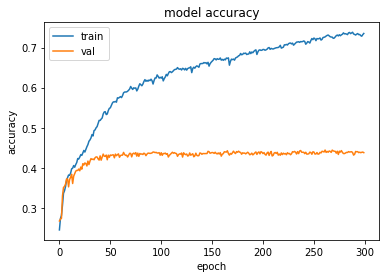

In [367]:
plt.plot(train_accuracy)
plt.plot(eval_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()